# Deep Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import tensorflow as tf
import numpy as np

>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

In [2]:
# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
rewards = []
for _ in range(100):
#     env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    rewards.append(reward)
    if done:
        print('state, action, reward, done, info')
        print(state, action, reward, done, info)
        rewards = []
        env.reset()

state, action, reward, done, info
[ 0.1646906   0.95760406 -0.24476933 -1.65176003] 0 1.0 True {}
state, action, reward, done, info
[-0.11620527 -0.22622795  0.21166559  0.60600704] 1 1.0 True {}
state, action, reward, done, info
[ 0.11681769  1.00196516 -0.21966337 -1.88059144] 1 1.0 True {}
state, action, reward, done, info
[ 0.05924112  0.7589715  -0.22008881 -1.54974618] 1 1.0 True {}
state, action, reward, done, info
[-0.18739119 -1.01598719  0.21403163  1.58246272] 0 1.0 True {}
state, action, reward, done, info
[ 0.15973027  1.00969828 -0.22342744 -1.73404178] 0 1.0 True {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
print(rewards[-20:])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [40]:
def model_input(state_size):
    # Given data
    inputs = tf.placeholder(tf.float32, [None, state_size], name='inputs')
    actions = tf.placeholder(tf.int32, [None], name='actions')

    # Target Q values for training
    targetQs = tf.placeholder(tf.float32, [None], name='target')
    return inputs, actions, targetQs 

In [41]:
def generator(inputs, hidden_size, action_size):
    with tf.variable_scope('generator'):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=inputs, units=hidden_size)
        #bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(0.1 * h1, h1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(nl1, hidden_size)
        #bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(0.1 * h2, h2)
        
        # Output layer
        logits = tf.layers.dense(nl2, action_size)
        # out = tf.tanh(logits)

        return logits

In [42]:
def model_loss(inputs, hidden_size, actions, action_size, targetQs):
    # Output layer
    output = generator(inputs=inputs, hidden_size=hidden_size, action_size=action_size)        

    # One hot encode the actions to later choose the Q-value for the action
    one_hot_actions = tf.one_hot(actions, action_size)

    ### Train with loss (targetQ - Q)^2
    # output has length 2, for two actions. This next line chooses
    # one value from output (per row) according to the one-hot encoded actions.
    Q = tf.reduce_sum(tf.multiply(output, one_hot_actions), axis=1)

    # error backpropagation: loss and opt
    loss = tf.reduce_mean(tf.square(targetQs - Q))
    
    return output, Q, loss

In [43]:
class QNetwork:
    def __init__(self, state_size, action_size, hidden_size):
        # Data of the Model: make the data available inside the framework
        self.inputs, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.output, self.Q, self.loss = model_loss(action_size=action_size, actions=self.actions, 
                                                    hidden_size=hidden_size, 
                                                    inputs=self.inputs, targetQs=self.targetQs)

        # Update the model: backward pass and backprop
        self.opt = tf.train.AdamOptimizer().minimize(self.loss)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [53]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [54]:
train_episodes = 2000          # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 10              # number of units in each Q-network hidden layer
state_size = 4                # number of units for the input state/observation
action_size = 2               # number of units for the output actions

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size

In [55]:
tf.reset_default_graph()
# mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)
mainQN = QNetwork(action_size=action_size, hidden_size=hidden_size, state_size=state_size)

## Populate the experience memory

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [56]:
# Initialize the simulation
env.reset()

# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

# init memory
memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for _ in range(batch_size):
    # Uncomment the line below to watch the simulation
    # env.render()

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Now train with experiences
saver = tf.train.Saver()

# Total rewards list for plotting
rewards_list = []

# TF session for training
with tf.Session() as sess:
    
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(train_episodes):
        total_reward = 0
        
        t = 0
        while t < max_steps:
            step += 1
            
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
    
            # Cumulative reward
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                
                # total rewards for plotting
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs: next_states})

            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)

            # Bellman equation
            targets = rewards + (gamma * np.max(target_Qs, axis=1))

            # Updating the model
            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs: states,
                                           mainQN.targetQs: targets,
                                           mainQN.actions: actions})
    # Save the trained model 
    saver.save(sess, "checkpoints/cartpole__.ckpt")

Episode: 0 Total reward: 7.0 Training loss: 1.0836 Explore P: 0.9993
Episode: 1 Total reward: 62.0 Training loss: 1.2512 Explore P: 0.9932
Episode: 2 Total reward: 15.0 Training loss: 1.6218 Explore P: 0.9917
Episode: 3 Total reward: 11.0 Training loss: 1.4843 Explore P: 0.9906
Episode: 4 Total reward: 47.0 Training loss: 2.0786 Explore P: 0.9860
Episode: 5 Total reward: 17.0 Training loss: 2.5077 Explore P: 0.9844
Episode: 6 Total reward: 26.0 Training loss: 2.7175 Explore P: 0.9819
Episode: 7 Total reward: 13.0 Training loss: 2.8599 Explore P: 0.9806
Episode: 8 Total reward: 23.0 Training loss: 6.4799 Explore P: 0.9784
Episode: 9 Total reward: 16.0 Training loss: 4.1816 Explore P: 0.9768
Episode: 10 Total reward: 16.0 Training loss: 3.3353 Explore P: 0.9753
Episode: 11 Total reward: 15.0 Training loss: 14.7664 Explore P: 0.9738
Episode: 12 Total reward: 28.0 Training loss: 28.1998 Explore P: 0.9711
Episode: 13 Total reward: 9.0 Training loss: 5.8040 Explore P: 0.9703
Episode: 14 Tota

Episode: 115 Total reward: 48.0 Training loss: 10.8156 Explore P: 0.7404
Episode: 116 Total reward: 16.0 Training loss: 2.1748 Explore P: 0.7392
Episode: 117 Total reward: 18.0 Training loss: 3.3955 Explore P: 0.7379
Episode: 118 Total reward: 60.0 Training loss: 2.2515 Explore P: 0.7336
Episode: 119 Total reward: 16.0 Training loss: 3.1361 Explore P: 0.7324
Episode: 120 Total reward: 47.0 Training loss: 23.2999 Explore P: 0.7290
Episode: 121 Total reward: 39.0 Training loss: 3.7501 Explore P: 0.7262
Episode: 122 Total reward: 13.0 Training loss: 2.3831 Explore P: 0.7253
Episode: 123 Total reward: 20.0 Training loss: 21.9681 Explore P: 0.7239
Episode: 124 Total reward: 50.0 Training loss: 2.2028 Explore P: 0.7203
Episode: 125 Total reward: 45.0 Training loss: 2.4473 Explore P: 0.7171
Episode: 126 Total reward: 64.0 Training loss: 29.1442 Explore P: 0.7126
Episode: 127 Total reward: 17.0 Training loss: 2.4426 Explore P: 0.7114
Episode: 128 Total reward: 99.0 Training loss: 34.6289 Explo

Episode: 228 Total reward: 106.0 Training loss: 61.0984 Explore P: 0.3604
Episode: 229 Total reward: 199.0 Training loss: 5.9793 Explore P: 0.3535
Episode: 230 Total reward: 173.0 Training loss: 376.4220 Explore P: 0.3476
Episode: 231 Total reward: 100.0 Training loss: 3.7250 Explore P: 0.3442
Episode: 232 Total reward: 110.0 Training loss: 13.1796 Explore P: 0.3406
Episode: 233 Total reward: 105.0 Training loss: 602.4109 Explore P: 0.3371
Episode: 234 Total reward: 178.0 Training loss: 12.1061 Explore P: 0.3313
Episode: 235 Total reward: 43.0 Training loss: 8.5226 Explore P: 0.3300
Episode: 236 Total reward: 199.0 Training loss: 8.5222 Explore P: 0.3237
Episode: 237 Total reward: 193.0 Training loss: 136.5909 Explore P: 0.3177
Episode: 238 Total reward: 135.0 Training loss: 35.5294 Explore P: 0.3135
Episode: 239 Total reward: 190.0 Training loss: 106.7571 Explore P: 0.3078
Episode: 240 Total reward: 172.0 Training loss: 10.1202 Explore P: 0.3027
Episode: 241 Total reward: 186.0 Traini

## Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [59]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total Reward')

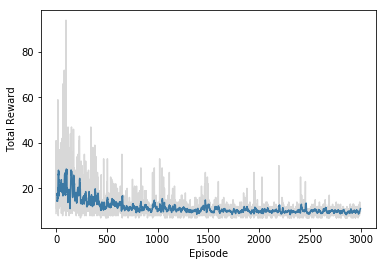

In [60]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Testing

Let's checkout how our trained agent plays the game.

In [13]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt


In [184]:
env.close()

## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.